<a href="https://colab.research.google.com/github/GrueneKatze/GANs_Coursera/blob/main/C1W2__DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Convolutional GAN (DCGAN)

##Goal
In this notebook, you're going to create another GAN using the MNIST dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

Note: here is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :) https://arxiv.org/pdf/1511.06434v1.pdf

##Learning Objectives
* Get hands-on experience making a widely used GAN: Deep Convolutional GAN (DCGAN).

* Train a powerful generative model.

Architectural drawing of a generator from DCGAN from Radford et al (2016)

##Getting Started
###DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!):

* Use convolutions without any pooling layers

* Use batchnorm in both the generator and the discriminator

* Don't use fully connected hidden layers

* Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.

* Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

##Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.

Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
  '''
  Generator Class
  Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
  '''
  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
          return nn.Sequential(
              #### START CODE HERE ####
              nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
              nn.BatchNorm2d(output_channels),
              nn.ReLU()
            )
        else:
          return nn.Sequential(
               
               nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
               nn.Tanh()
                #### END CODE HERE ####
          )

  def unsqueeze_noise(self, noise):
      return noise.view(len(noise), self.z_dim, 1, 1)


      #'''
      #        Function for completing a forward pass of the generator: Given a noise tensor, 
      #        returns a copy of that noise with width and height = 1 and channels = z_dim.
      #        Parameters:
      #            noise: a noise tensor with dimensions (n_samples, z_dim)
      #        '''
        

  def forward(self, noise):
      x = self.unsqueeze_noise(noise)
      return self.gen(x)
      #      '''
      #     Function for completing a forward pass of the generator: Given a noise tensor, 
      #       returns generated images.
      #       Parameters:
      #           noise: a noise tensor with dimensions (n_samples, z_dim)
      #       '''
  

def get_noise(n_samples, z_dim, device='cpu'):
      '''
      Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
      creates a tensor of that shape filled with random numbers from the normal distribution.
      Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
      '''
      return torch.randn(n_samples, z_dim, device=device)

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [ ]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


##Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.

There are also tests at the end for you to use.

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
               
               nn.Conv2d(input_channels, output_channels, kernel_size, stride),
               
               #### END CODE HERE ####
            )
      
    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [ ]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


##Training
Now you can put it all together! Remember that these are your parameters:

* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* beta_1, beta_2: the momentum term
* device: the device type

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN! For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse.

Step 500: Generator loss: 0.8748693290948872, discriminator loss: 0.5086652448177331


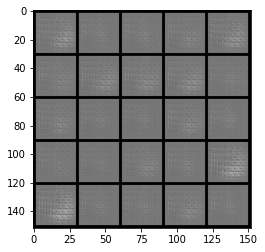

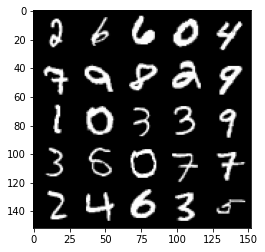

Step 1000: Generator loss: 1.5255574243664731, discriminator loss: 0.3451783257126809


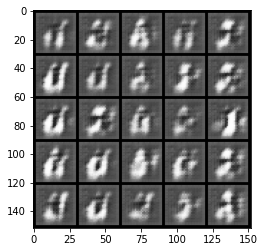

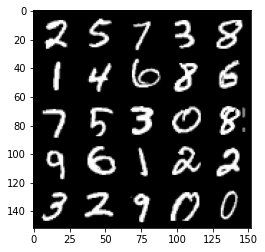

Step 1500: Generator loss: 1.2856067277491077, discriminator loss: 0.47736906602978746


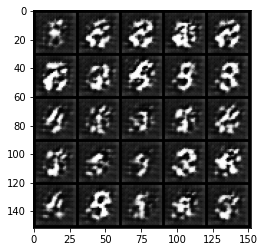

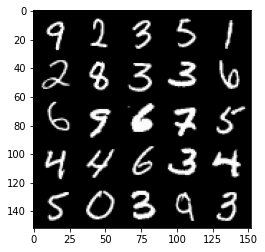

Step 2000: Generator loss: 1.0103871212899687, discriminator loss: 0.5469740718007086


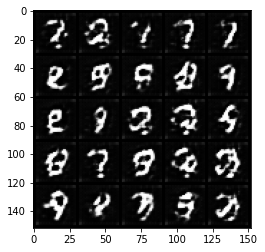

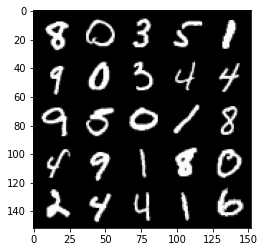

Step 2500: Generator loss: 0.8651810894012447, discriminator loss: 0.6131822836399078


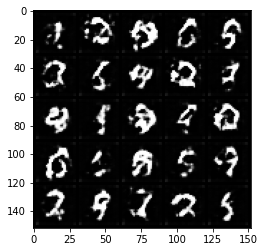

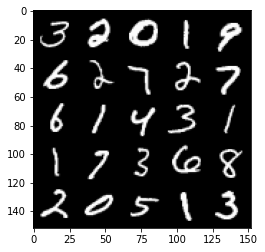

Step 3000: Generator loss: 0.8125608292222032, discriminator loss: 0.6374690151214596


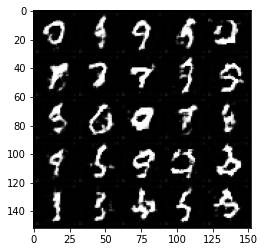

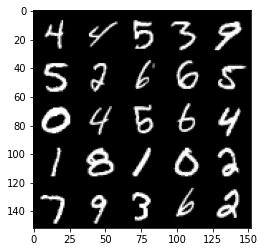

Step 3500: Generator loss: 0.7814080414175991, discriminator loss: 0.6508312847614294


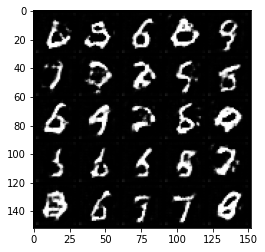

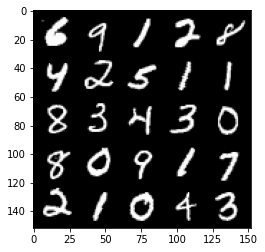

Step 4000: Generator loss: 0.7713824157714844, discriminator loss: 0.6606102358102797


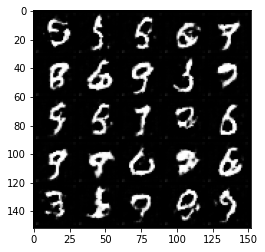

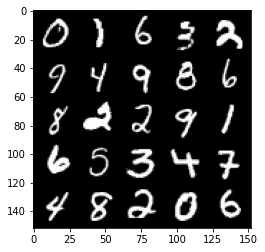

Step 4500: Generator loss: 0.7742509843111032, discriminator loss: 0.6620376746654507


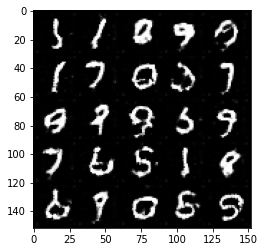

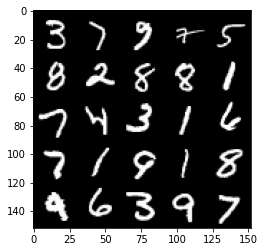

Step 5000: Generator loss: 0.7722618715763093, discriminator loss: 0.6631584032773973


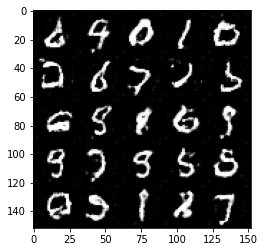

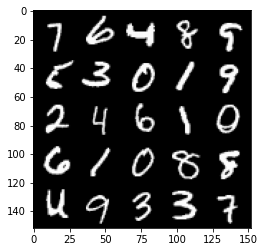

Step 5500: Generator loss: 0.764694222569466, discriminator loss: 0.6713827766180042


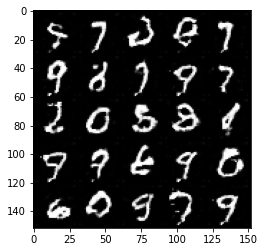

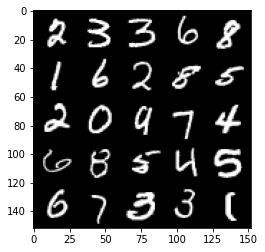

Step 6000: Generator loss: 0.7593466261625286, discriminator loss: 0.6762262225151062


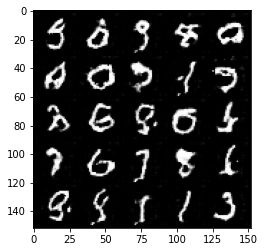

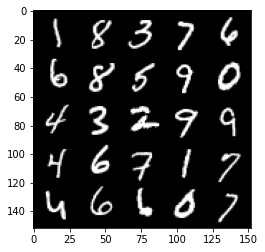

Step 6500: Generator loss: 0.7521261349916455, discriminator loss: 0.6771055928468711


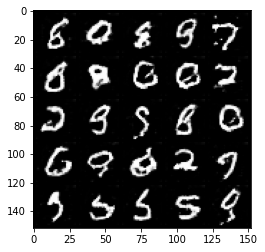

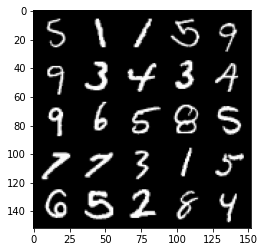

Step 7000: Generator loss: 0.7449021108150482, discriminator loss: 0.6818305463790899


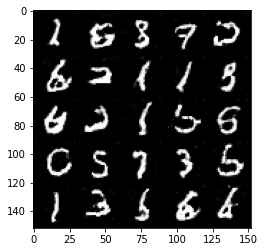

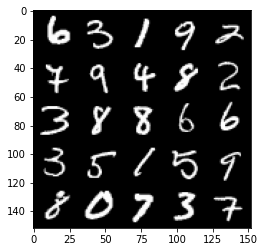

Step 7500: Generator loss: 0.7422829625010489, discriminator loss: 0.6860008920431135


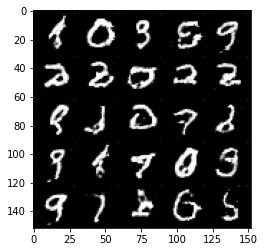

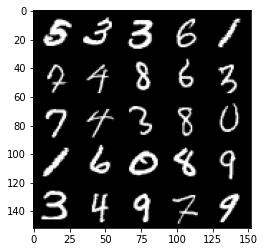

Step 8000: Generator loss: 0.7347955884933474, discriminator loss: 0.6870972437858583


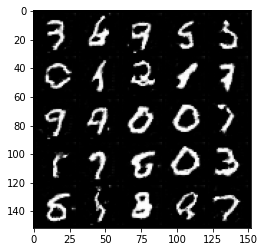

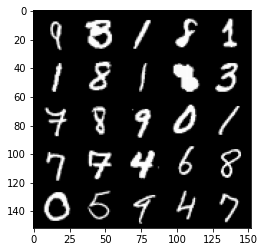

Step 8500: Generator loss: 0.7323759022951135, discriminator loss: 0.6907958086729056


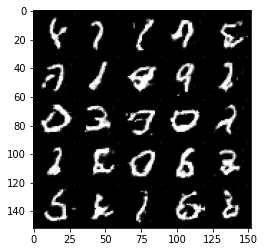

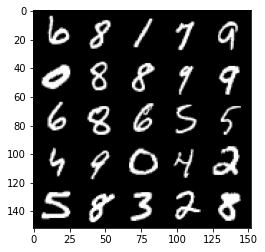

Step 9000: Generator loss: 0.7278006287813186, discriminator loss: 0.6909169611930849


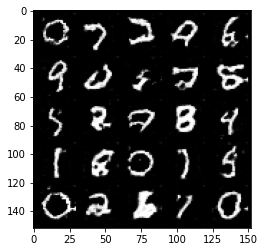

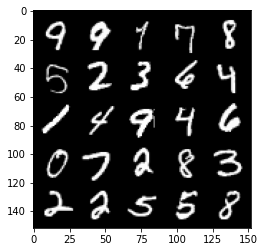

Step 9500: Generator loss: 0.7183689849972725, discriminator loss: 0.6933659936189646


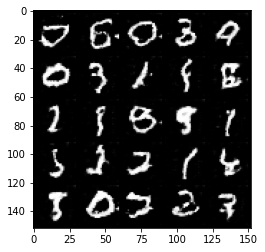

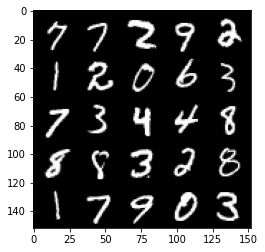

Step 10000: Generator loss: 0.7182925686836246, discriminator loss: 0.6955348666906358


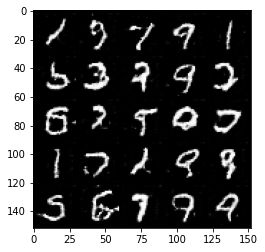

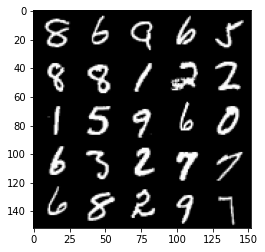

Step 10500: Generator loss: 0.7182568526864052, discriminator loss: 0.694627082705498


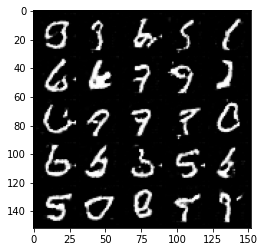

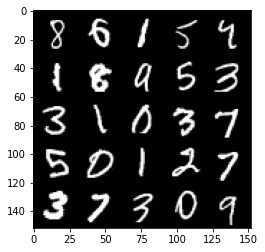

Step 11000: Generator loss: 0.7143799617290496, discriminator loss: 0.6952230391502382


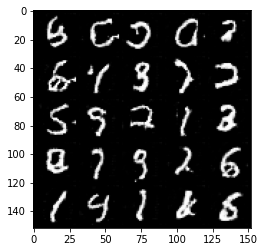

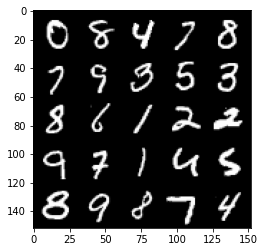

Step 11500: Generator loss: 0.7157719662189481, discriminator loss: 0.696257442116738


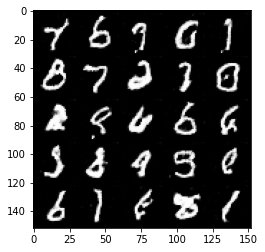

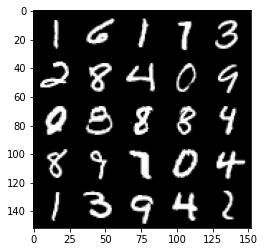

Step 12000: Generator loss: 0.7104761202335355, discriminator loss: 0.6956764285564423


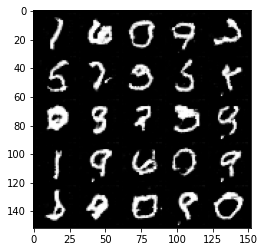

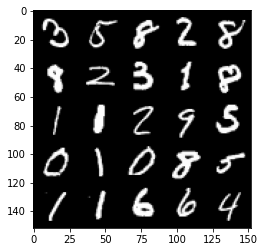

Step 12500: Generator loss: 0.7108683043718343, discriminator loss: 0.6965254527330391


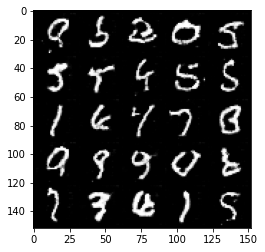

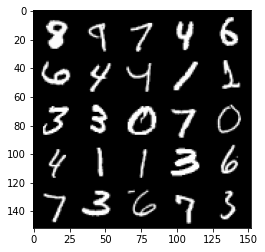

Step 13000: Generator loss: 0.7084992834925649, discriminator loss: 0.6964101531505587


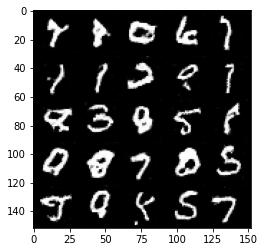

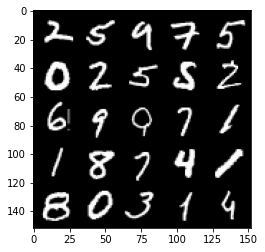

Step 13500: Generator loss: 0.7052253282070164, discriminator loss: 0.6966402212381361


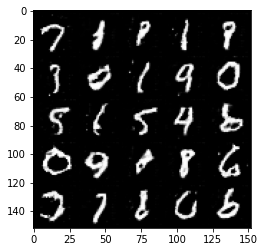

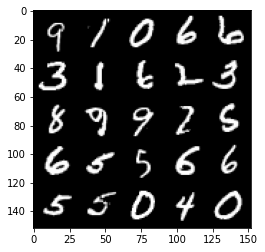

Step 14000: Generator loss: 0.707116939783097, discriminator loss: 0.6972465482950202


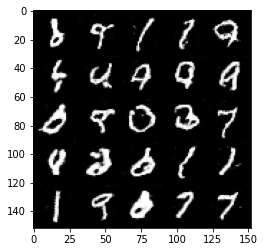

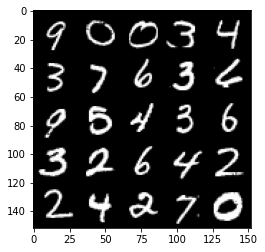

Step 14500: Generator loss: 0.7066403927803039, discriminator loss: 0.6971906272172929


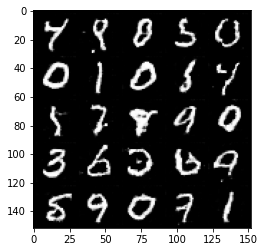

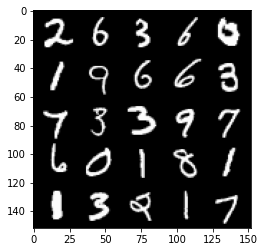

Step 15000: Generator loss: 0.7054070975780482, discriminator loss: 0.6973647191524511


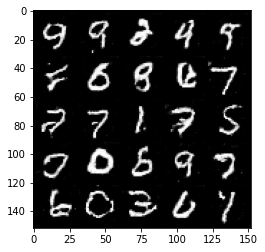

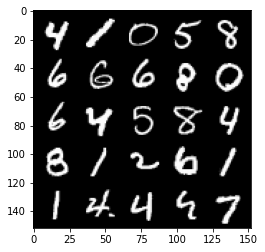

Step 15500: Generator loss: 0.7042840278148643, discriminator loss: 0.6968892158269879


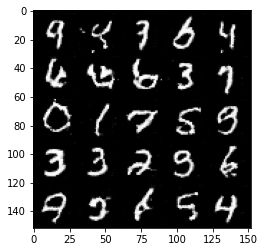

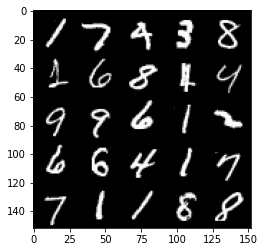

Step 16000: Generator loss: 0.7039790431857109, discriminator loss: 0.6972477055788041


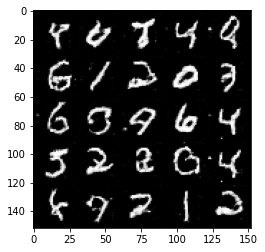

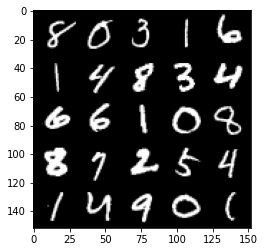

Step 16500: Generator loss: 0.7007065966129304, discriminator loss: 0.6969099094867701


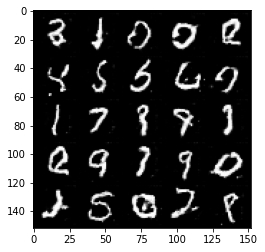

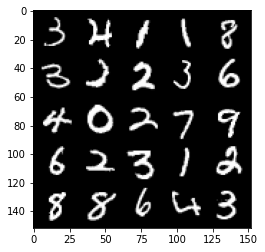

Step 17000: Generator loss: 0.7022472100257874, discriminator loss: 0.6971644867658618


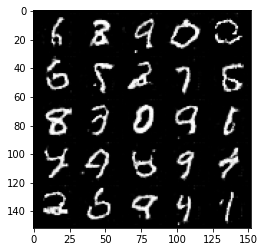

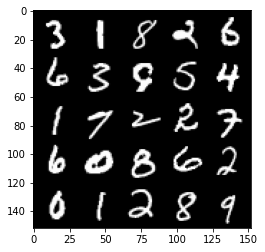

Step 17500: Generator loss: 0.6983988199234015, discriminator loss: 0.6966528443098068


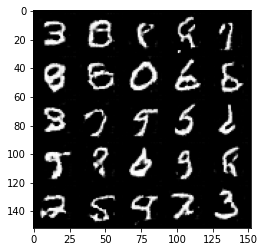

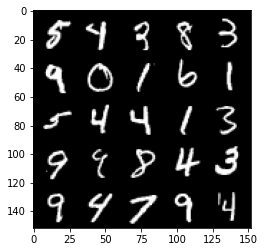

Step 18000: Generator loss: 0.7026219836473466, discriminator loss: 0.6967100741863251


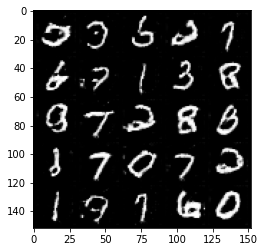

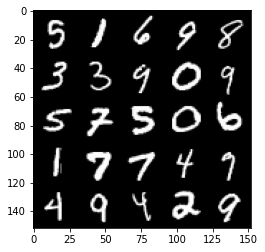

Step 18500: Generator loss: 0.7004776786565766, discriminator loss: 0.6962355237007134


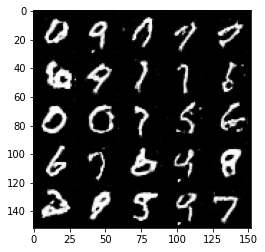

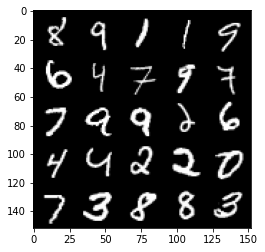

Step 19000: Generator loss: 0.6978253035545353, discriminator loss: 0.696258558988571


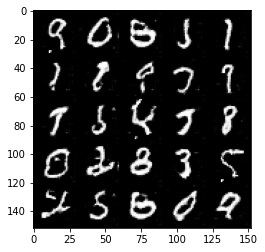

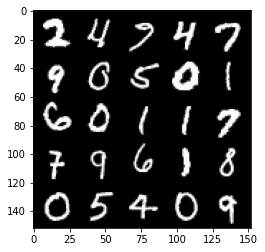

Step 19500: Generator loss: 0.7003571085929875, discriminator loss: 0.6961413682699202


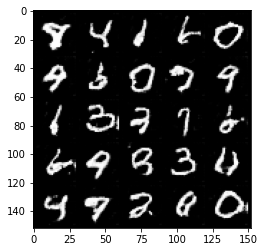

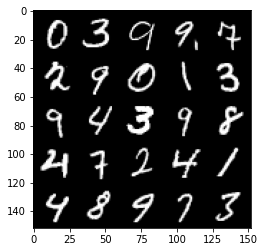

Step 20000: Generator loss: 0.6983711370229725, discriminator loss: 0.6955782545804975


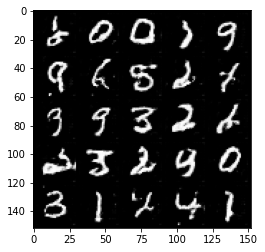

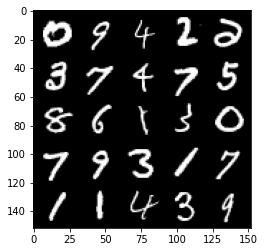

Step 20500: Generator loss: 0.6974527317285538, discriminator loss: 0.695761033177375


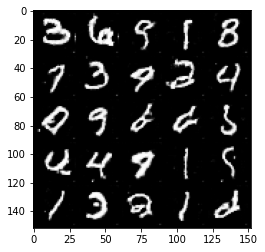

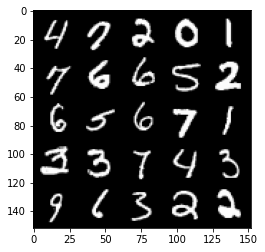

Step 21000: Generator loss: 0.6980607312917712, discriminator loss: 0.695633296608925


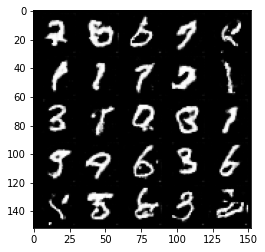

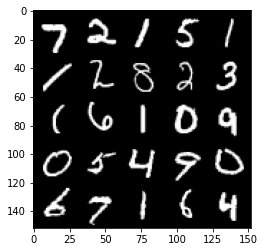

Step 21500: Generator loss: 0.6979900516271592, discriminator loss: 0.6953230533599847


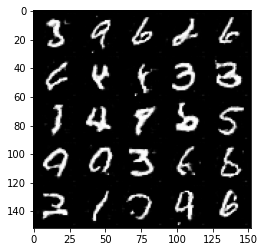

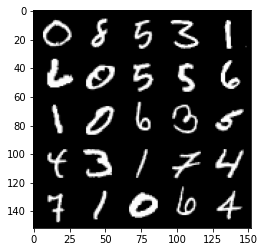

Step 22000: Generator loss: 0.6966160466670996, discriminator loss: 0.6953344128131871


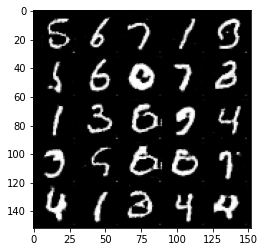

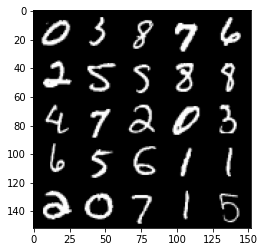

Step 22500: Generator loss: 0.6975868535041807, discriminator loss: 0.6947603814601894


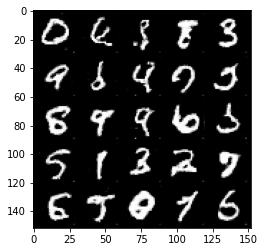

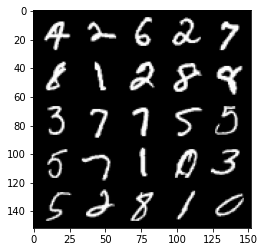

Step 23000: Generator loss: 0.6974644149541855, discriminator loss: 0.6945298122167594


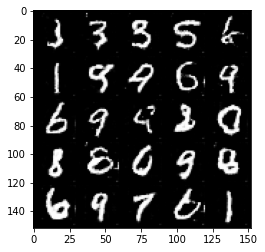

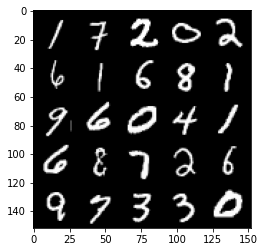

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [ ]:
#nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) 
#and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html)